# Wealthfront Take-Home

This notebook is a walk through of code solution for the Sr. Data Science interview homework assignment. This notebook is optimized for training. To score in a production environment, the model needs to be stored (pickle, mlflow, etc) and then called for scoring. 

<b>Author:</b> Hannah Jones

<b>Date:</b> 2023-12-02

## Assignment Description

You work for a lending company that provides small loans to individual borrowers for 3 or 5 years. The company has collected data on the loans granted in the past few years. Your responsibility is to conduct an analysis of the data and retrieve key data insights as described below.

**Tasks**
1. Implement one or more models to predict whether a loan will be "good" or "bad"
2. Assess the performance of your models, using statistics or charts as necessary
3. Discuss the implications of your work and any insights you have uncovered

## Env Set Up

In [209]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [210]:
# import csv data
df = pd.read_csv("loan_data.csv")
print(df.shape)

(10000, 29)


In [211]:
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,wtd_loans,interest_rate,int_rate2,num_rate,numrate,int_rate3
0,571203,18000,18000,60 months,10.16,383.87,10+ years,MORTGAGE,72804.0,Current,credit_card,MA,16.73,0.0,1995-12-27 02:06:00,NaN,21.0,8751.0,49.0,13263.18,7273.77,4736.82,2536.95,NaN,NaN,10.16%,NaN,NaN,10.16
1,694891,15675,15675,36 months,8.90,497.74,10+ years,MORTGAGE,100000.0,Current,small_business,WA,9.10,0.0,1994-04-07 12:00:00,NaN,16.0,20650.0,45.0,15294.25,496.78,380.75,116.03,NaN,NaN,8.90%,NaN,NaN,8.90
2,784712,16500,16500,60 months,7.90,333.78,2 years,MORTGAGE,42000.0,Late (31-120 days),small_business,NY,10.43,0.0,1993-07-16 08:41:00,NaN,9.0,2229.0,17.0,12966.64,5000.85,3533.36,1467.49,NaN,NaN,7.90%,NaN,NaN,7.90
3,843448,5500,5500,36 months,13.67,187.10,3 years,RENT,55000.0,Fully Paid,debt_consolidation,NJ,20.71,0.0,1987-07-24 12:40:00,NaN,17.0,9486.0,25.0,0.00,5792.14,5500.00,292.14,NaN,NaN,13.67%,NaN,NaN,13.67
4,974654,6400,6400,36 months,15.80,224.38,2 years,RENT,34000.0,Current,debt_consolidation,VA,32.40,0.0,1998-03-15 06:57:00,47.0,6.0,4915.0,15.0,4430.59,2912.26,1969.41,942.85,NaN,NaN,15.80%,NaN,NaN,15.80


## Exploratory Data Analysis

In [212]:
df.isna().sum()

id                            0
loan_amnt                     0
funded_amnt                   0
term                        476
int_rate                    476
installment                 476
emp_length                  881
home_ownership              476
annual_inc                  476
loan_status                 476
purpose                     476
addr_state                    0
dti                         476
delinq_2yrs                 476
earliest_cr_line            476
mths_since_last_delinq     5900
open_acc                    476
revol_bal                   476
total_acc                   476
out_prncp                   476
total_pymnt                 476
total_rec_prncp             476
total_rec_int               476
wtd_loans                 10000
interest_rate             10000
int_rate2                   476
num_rate                  10000
numrate                   10000
int_rate3                   476
dtype: int64

In [213]:
# remove columns that have all null values

df = df.dropna(axis=1, how='all')

In [214]:
# remove duplicate columns

df = df.drop(columns=['int_rate2', 'int_rate3'])

In [215]:
# remove all rows that have more than 20 null attributes

df = df.dropna(thresh=20) 

In [216]:
# check for duplicate rows

(df.groupby(df.columns.tolist(),as_index=False).size()['size'] > 2).sum()

0

## Target Creation
A target is considered "bad" if it is in **Default** or **Charged Off**. 

In [218]:
df['loan_status'].value_counts(normalize=True)

loan_status
Current               0.852793
Fully Paid            0.099853
Charged Off           0.022890
Late (31-120 days)    0.015540
In Grace Period       0.005040
Late (16-30 days)     0.002205
Default               0.001680
Name: proportion, dtype: float64

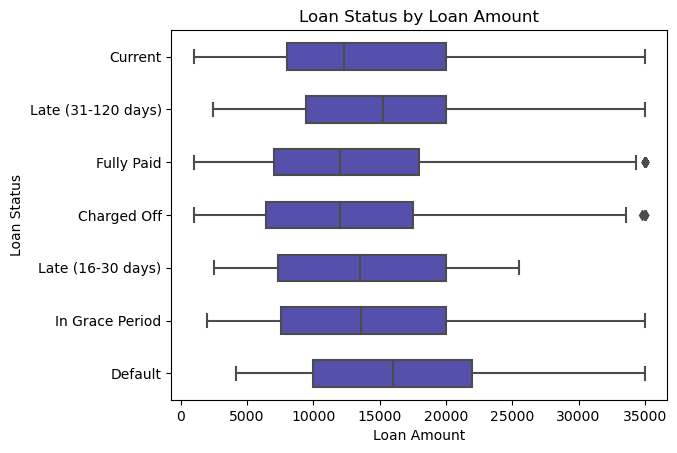

In [219]:
sns.boxplot(data=df, x="loan_amnt", y="loan_status", width=.5, color='#4841bb')
plt.title("Loan Status by Loan Amount")

plt.xlabel("Loan Amount")
plt.ylabel("Loan Status")

plt.show()

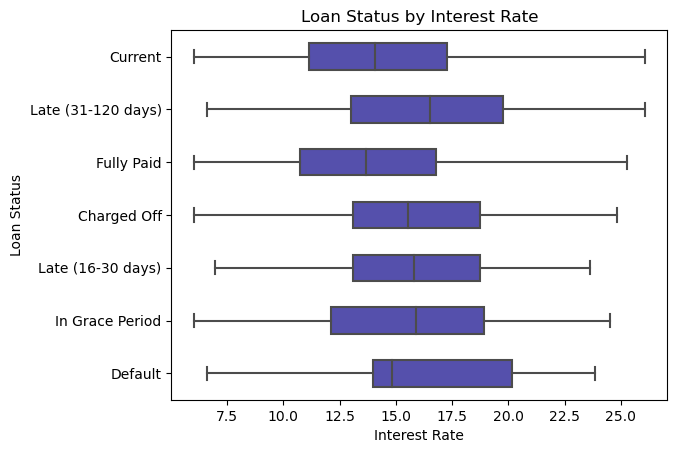

In [220]:
sns.boxplot(data=df, x="int_rate", y="loan_status", width=.5, color='#4841bb')
plt.title("Loan Status by Interest Rate")

plt.xlabel("Interest Rate")
plt.ylabel("Loan Status")

plt.show()

In [221]:
df['target'] = df['loan_status'].apply(lambda x: 1 if x == 'Default' or x == 'Charged Off' else 0)
df = df.drop(columns='loan_status')
print(f"Bad Loan rate: {df.target.mean():.2%}")

Bad Loan rate: 2.46%


### Evaluate categorical variables

* `term`: One-hot encode where 0 = 36 months, 1 = 60 months
* `emp_length`: Convert to integer
* `home_ownership`: None
* `loan_status`: None
* `earliest_cr_line`: Convert to year (ideally, i would like to explore the lift between using the entire date versus only the year)

In [222]:
# term 
term_label_encoder = LabelEncoder()
df['term'] = term_label_encoder.fit_transform(df['term']) # 60 > 30, 1 > 0

In [223]:
# emp_length
df['emp_length'] = df['emp_length'].str.replace('< 1 year', '0')
df['emp_length'] = df['emp_length'].str.extract(r'([0-9]*)')

In [224]:
# earliest_cr_line
max(df['earliest_cr_line'].str.extract(r'([0-9]{4})')[0])
df['earliest_cr_line'] = df['earliest_cr_line'].str.extract(r'([0-9]{4})').astype(int)

### Evaluate numerical columns

In [225]:
num_cols = df.select_dtypes('number').columns
num_cols = num_cols[1:len(num_cols)]

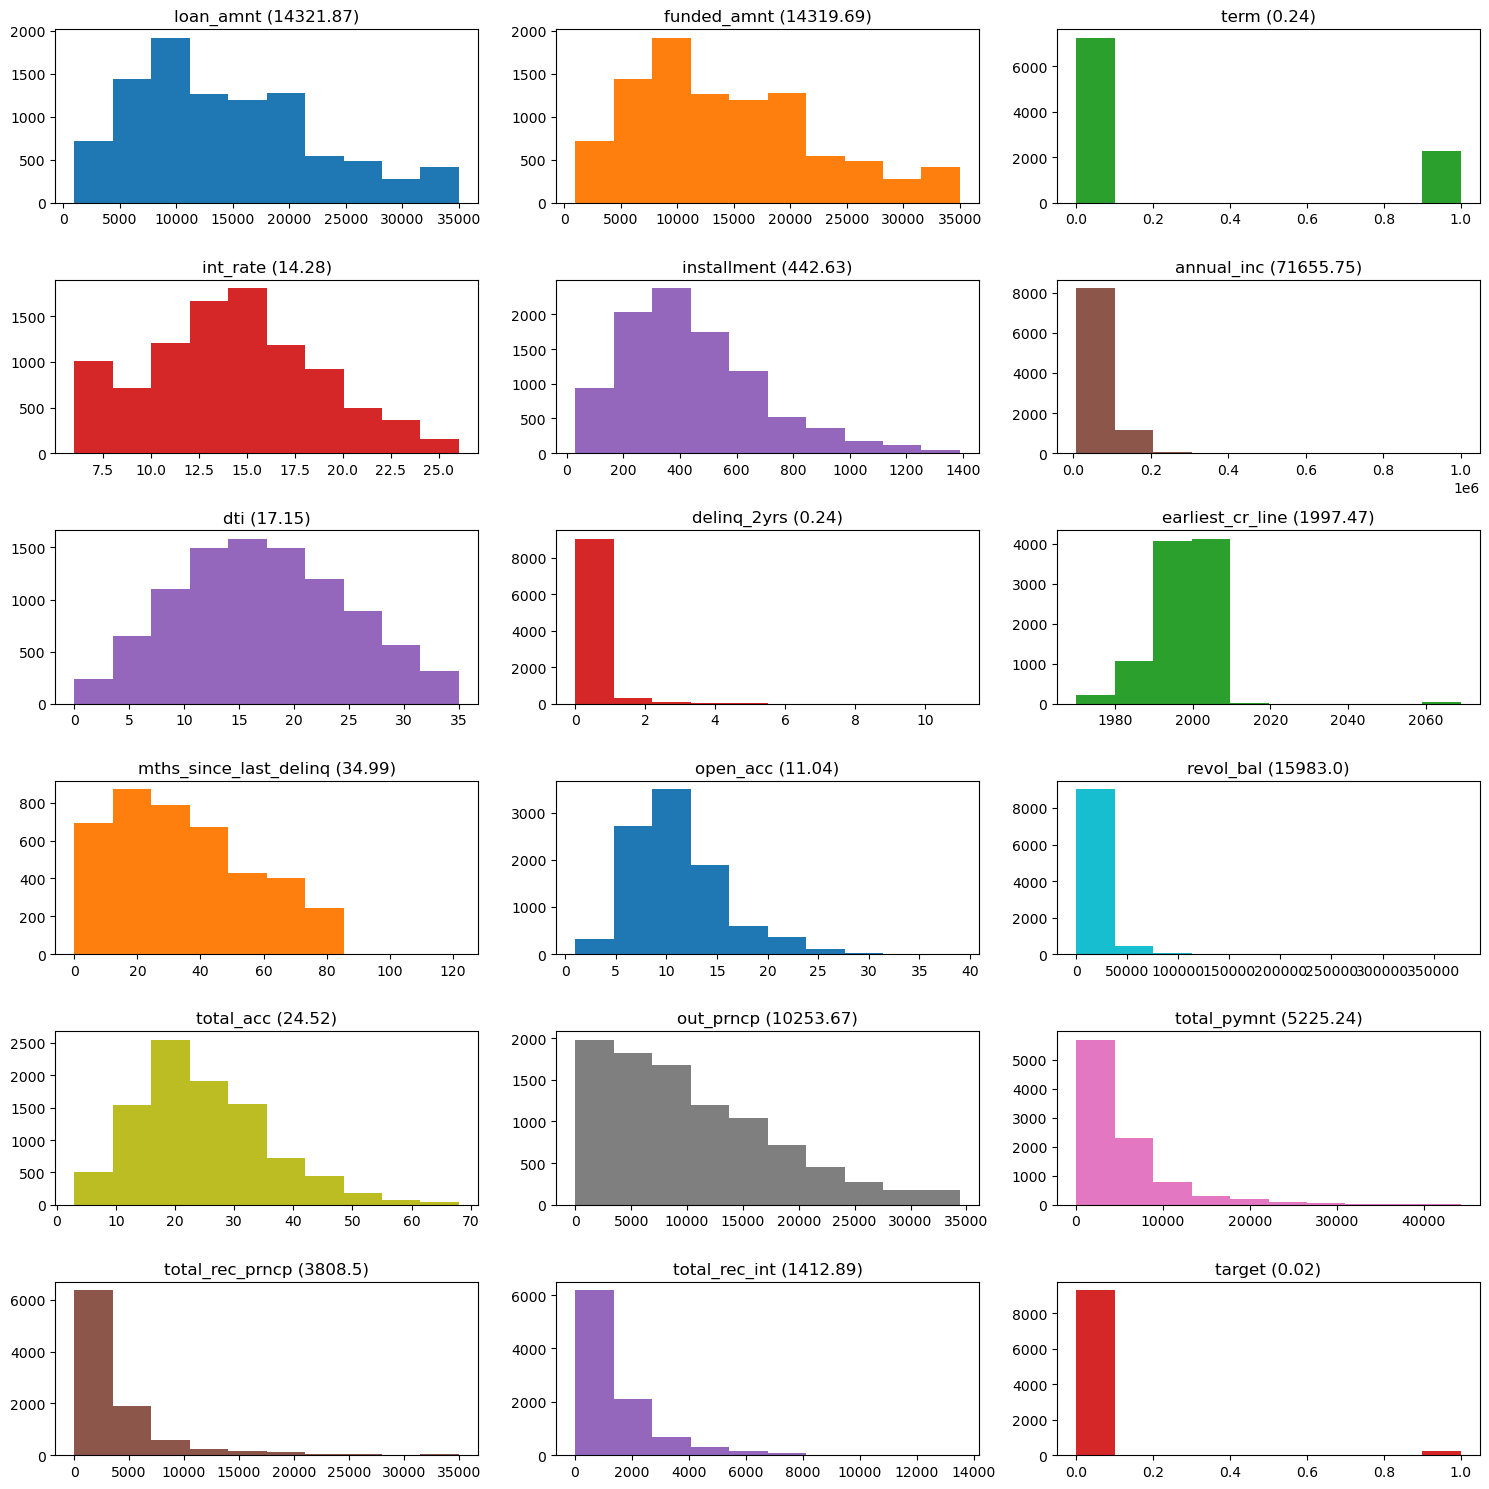

In [226]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

rows = 6
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
colors = list(mcolors.TABLEAU_COLORS.values())

axes = axes.flatten()

for i in range(rows*cols):
    axes[i].hist(df[num_cols[i]], color=colors[min(10-i,i)])
#     sns.violinplot(x=df[num_cols[i]], ax=axes[i], color=colors[min(10 - i, i)])
    axes[i].set_title(f'{num_cols[i]} ({round(df[num_cols[i]].mean(),2)})')
    
plt.tight_layout()

plt.show()

In [227]:
# remove rows with earliest line of credit outliers

df = df[df["earliest_cr_line"] < 2023]

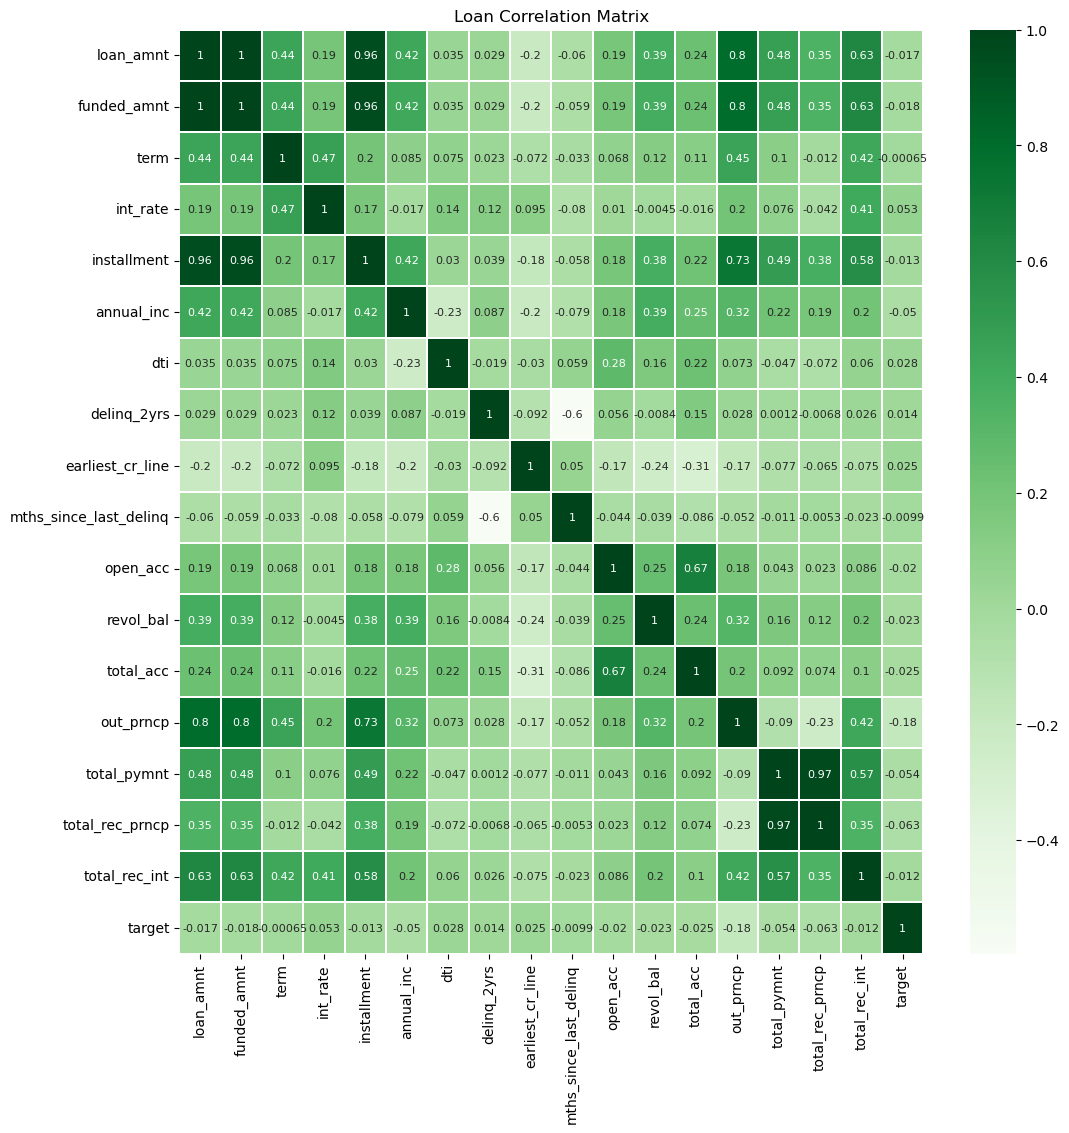

In [228]:
# correlation matrix

plt.figure(figsize=(12, 12))

sns.heatmap(df[num_cols].corr(), annot=True, linewidths=.1, annot_kws={"size": 8}, cmap="Greens")

plt.title("Loan Correlation Matrix")

plt.show()

We see multiple variables that suffer from extreme collinearity. 

1. `loan_amnt`, `funded_amnt`

`loan_amnt` is dropped due to high correlation with `funded_amnt`

Fortunately, we observe no columns have an extremely high correlation with our target.

In [229]:
df = df.drop(columns=['funded_amnt','id'])
df = df.reset_index(drop=True)

In [ ]:
print(f"Final dataframe: {df.shape}")

# Model

### Training

In [230]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

import catboost as cb
from catboost import Pool, CatBoostClassifier

import xgboost as xgb

import shap 

In [231]:
TARGET_COL = 'target'

### Catboost

In [232]:
d_train, d_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training: {d_train.shape}, Test: {d_test.shape}")

Training: (7595, 21), Test: (1899, 21)


In [233]:
params = {
    'random_seed': 12,
    'loss_function':'Logloss',
    'depth': 5,
    'metric_period': 100,
    'iterations': 500,
    'learning_rate': 0.05,
    'use_best_model': True,
    'od_type':'Iter',
    'od_wait':200,
#     'auto_class_weights':True,
}

In [234]:
# prepare data
cat_cols = [c for c in d_train.columns if d_train[c].dtype == 'object']
d_train[cat_cols] = d_train[cat_cols].fillna('NA')
d_train[cat_cols] = d_train[cat_cols].apply(lambda c: c.str.strip())

# split data
train, val = train_test_split(d_train, test_size=0.1)
y_train = train.pop(TARGET_COL)
y_val = val.pop(TARGET_COL)
val_set = Pool(data=val, label=y_val, cat_features=cat_cols)

model = CatBoostClassifier(**params)
model.fit(train, y_train, eval_set=val_set, cat_features=cat_cols, verbose=True)

0:	learn: 0.6067211	test: 0.6076926	best: 0.6076926 (0)	total: 5.43ms	remaining: 2.71s


100:	learn: 0.0138806	test: 0.0208600	best: 0.0207976 (86)	total: 380ms	remaining: 1.5s
200:	learn: 0.0099761	test: 0.0213465	best: 0.0207288 (101)	total: 754ms	remaining: 1.12s
300:	learn: 0.0068103	test: 0.0221838	best: 0.0207288 (101)	total: 1.13s	remaining: 746ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.02072883179
bestIteration = 101

Shrink model to first 102 iterations.


### Model Evaluation

In [235]:
test_full = d_test.copy()
test = d_test[[c for c in d_test.columns if c != TARGET_COL]]

In [236]:
cat_cols = [c for c in test.columns if df[c].dtype == 'object']
test[cat_cols] = test[cat_cols].fillna('NA')
test[cat_cols] = test[cat_cols].apply(lambda c: c.str.strip())


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [237]:
threshold = 0.5

In [238]:
probs = model.predict_proba(Pool(data=test, cat_features=cat_cols))[:,1]
pred_class = probs > threshold
pred_class = pred_class.astype(int)
test_full['pred_class'] = pred_class

y_true = test_full[TARGET_COL]
y_pred = test_full['pred_class']

In [239]:
print(f"True Bad Loan Rate: {test_full[TARGET_COL].mean()}")
print(f"Predicted Bad Loan Rate: {test_full['pred_class'].mean()}")

True Bad Loan Rate: 0.02527646129541864
Predicted Bad Loan Rate: 0.02422327540810953


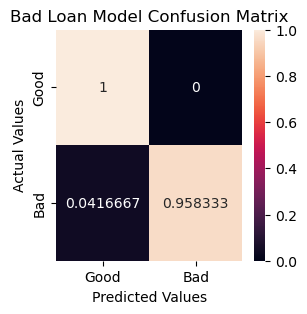

In [240]:
labels = ['Good','Bad']
cm = metrics.confusion_matrix(y_true, y_pred,normalize='true')
cm_df = pd.DataFrame(cm, columns=labels, index=labels)

plt.figure(figsize=(3,3))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title(f'Bad Loan Model Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [241]:
model_metrics = {}
model_metrics['Precision'] = metrics.precision_score(y_true, y_pred)
model_metrics['Recall'] = metrics.recall_score(y_true, y_pred)
model_metrics['F1'] = metrics.f1_score(y_true, y_pred)
model_metrics['Accuracy'] = metrics.accuracy_score(y_true, y_pred)
model_metrics['LogLoss'] = metrics.log_loss(y_true, y_pred)

In [242]:
d_metrics = pd.DataFrame(list(model_metrics.items()), columns=['Metric', 'Value'])
d_metrics.set_index('Metric', inplace=True)
d_metrics

,Value
Metric,
Precision,1.000000
Recall,0.958333
F1,0.978723
Accuracy,0.998947
LogLoss,0.037961


## Model Explainability

In [243]:
explainer = shap.TreeExplainer(model)
shap_obj = explainer(test)
shap_values = explainer.shap_values(test)

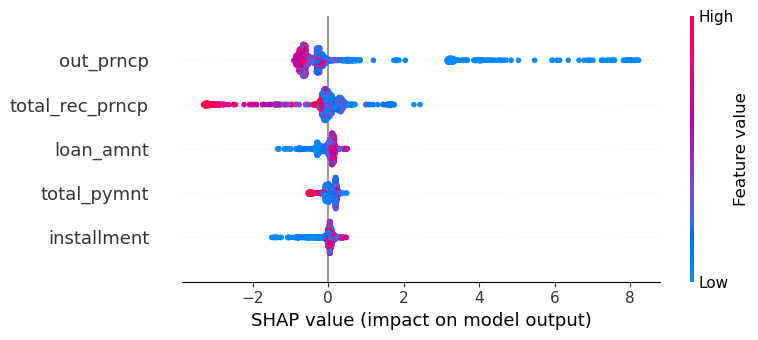

In [244]:
shap.summary_plot(shap_values, test.values, feature_names = test.columns, max_display=5)

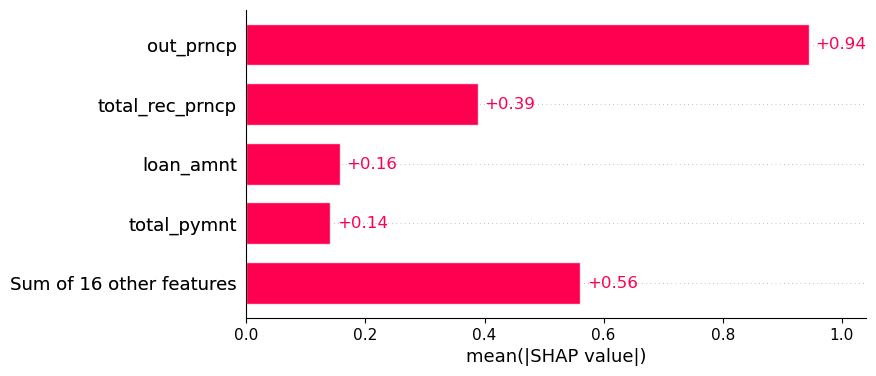

In [245]:
shap.plots.bar(shap_obj, max_display=5)

### Error Analysis

In [249]:
test_full[test_full[TARGET_COL] != test_full['pred_class']].shape[0]

2

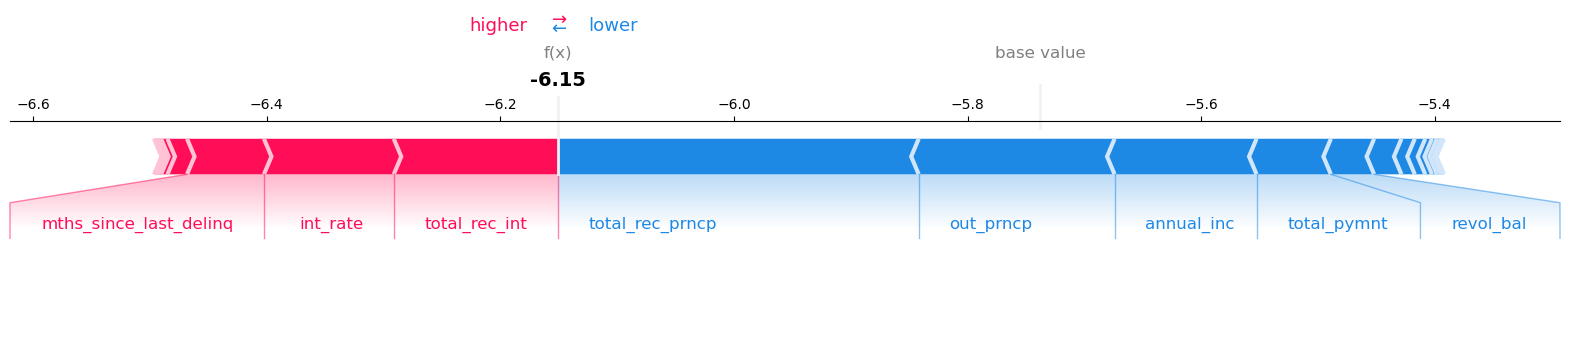

In [254]:
idx = test_full[test_full[TARGET_COL] != test_full['pred_class']].index[1]
shap.plots.force(explainer.expected_value, shap_values[idx], matplotlib=True, features=test.columns)

In [ ]:
## Save and deploy model after this command